Epoch 1/100


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: nan
Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: n

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
        date  predicted_heatwave heatwave
0 2022-07-26                   0       No
1 2022-07-27                   0       No
2 2022-07-28                   0       No
3 2022-07-29                   0       No
4 2022-07-30                   0       No


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


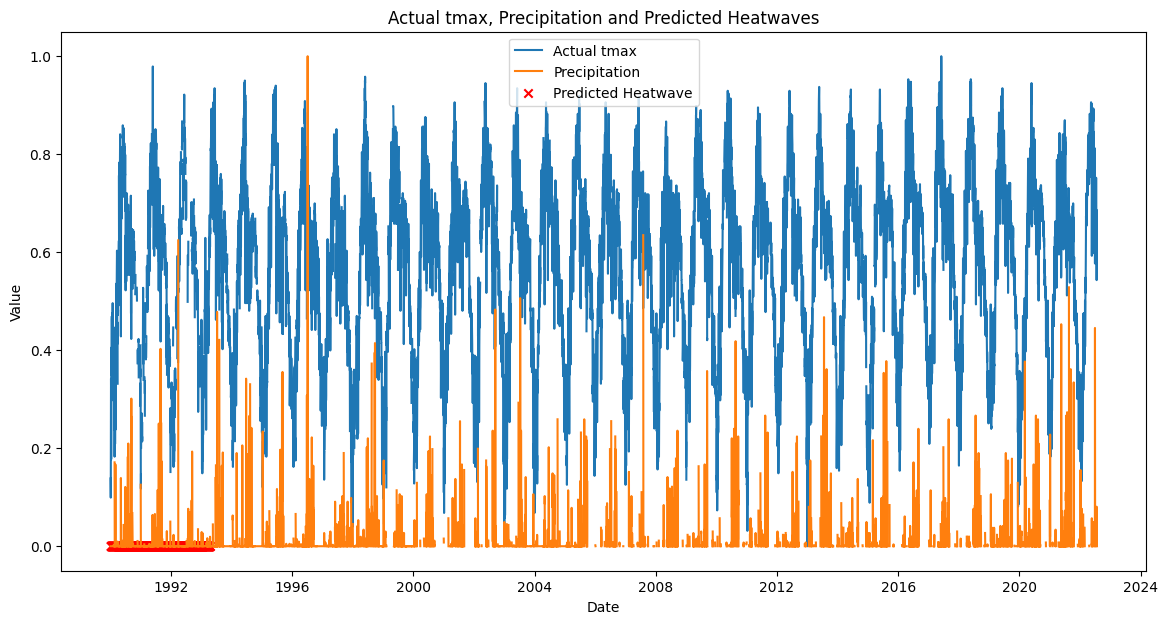

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = '12delhi.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence
        new_entry = np.zeros((1, len(features)))  # Placeholder for new entry
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


Epoch 1/10


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6814 - loss: 0.6129 - val_accuracy: 1.0000 - val_loss: 0.0966
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9943 - loss: 0.0928 - val_accuracy: 1.0000 - val_loss: 0.0149
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9999 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 7.5457e-04
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 8.7755e-04 - val_accuracy: 1.0

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
        date  predicted_heatwave heatwave
0 2022-07-26                   0       No
1 2022-07-27                   0       No
2 2022-07-28                   0       No
3 2022-07-29                   0       No
4 2022-07-30                   0       No


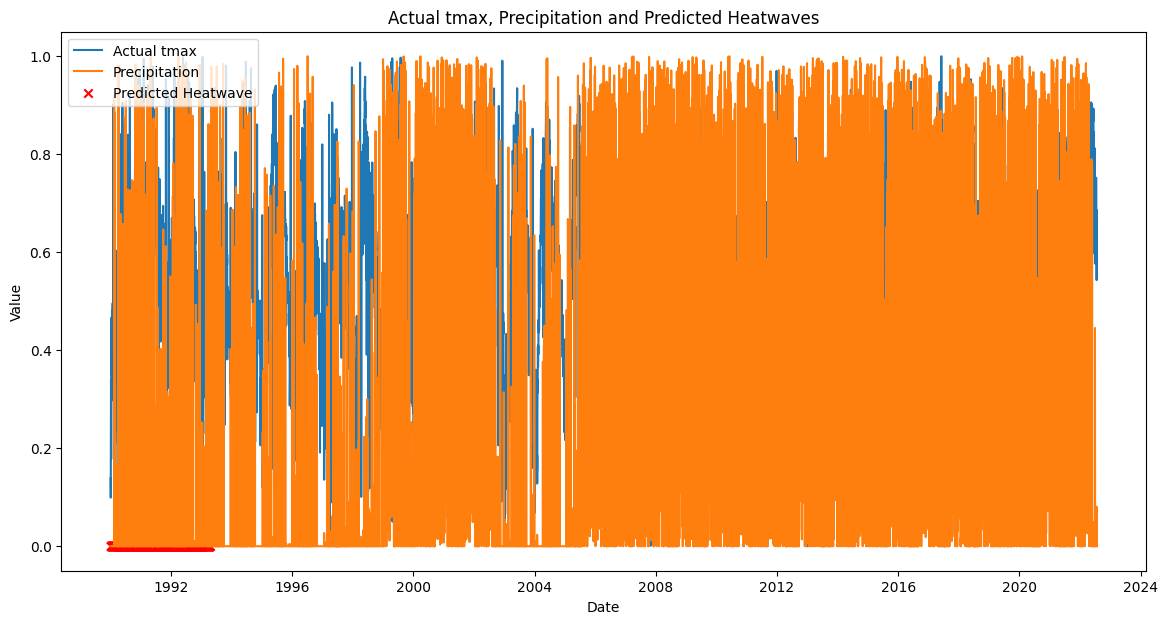

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import timedelta

# Load the data from a CSV file
file_path = '12delhi.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y")
data.set_index('time', inplace=True)
features = ['tavg', 'tmin', 'tmax', 'prcp']

# Function to fill NaNs with random values within the range of each column
def fill_na_randomly(df, columns):
    for column in columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = df[column].apply(
            lambda x: np.random.uniform(min_val, max_val) if pd.isna(x) else x
        )
    return df

# Fill NaNs with random values within the range of each column
data = fill_na_randomly(data, features)

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tmax > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=1, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence with the new prediction (assuming the same range for tavg, tmin, tmax, prcp)
        new_entry = np.random.uniform(scaler.data_min_, scaler.data_max_, (1, len(features)))
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tmax'], label='Actual tmax')
plt.plot(data.index, data['prcp'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual tmax, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")
